In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
tf.executing_eagerly()
tf.compat.v1.enable_eager_execution()

In [34]:
df = pd.read_excel("Test dataset v1.xlsx")
df.head()

,Period,EQ,Social_Search_Impressions,Social_Search_Working_cost,Digital_Impressions,Digital_Working_cost,Print_Impressions.Ads40,Print_Working_Cost.Ads50,OOH_Impressions,OOH_Working_Cost,SOS_pct,Digital_Impressions_pct,CCFOT,Median_Temp,Median_Rainfall,Fuel_Price,Inflation,Trade_Invest,Brand_Equity,Avg_EQ_Price,Any_Promo_pct_ACV,Any_Feat_pct_ACV,Any_Disp_pct_ACV,EQ_Base_Price,Est_ACV_Selling,pct_ACV,Avg_no_of_Items,pct_PromoMarketDollars_Category,RPI_Category,Magazine_Impressions_pct,TV_GRP,Competitor1_RPI,Competitor2_RPI,Competitor3_RPI,Competitor4_RPI,EQ_Category,EQ_Subcategory,pct_PromoMarketDollars_Subcategory,RPI_Subcategory
0,2016 - Period:1,504.784933,2019283.0,5493.0,37148.2,2045.282,0.000012,0.000012,1.203045e+09,2220633.0,7.446883,16.0,100.0,32.950,0.5150,8.226,0.013258,42744.256840,42.410000,49.091447,9.691794,2.87,1.688896,1.427532,8696587915,39.441025,2.611782,0.0339,35.817030,27.702433,21.300,97.173365,35.557371,44.502717,63.377268,1728388.673,331927.5394,0.162732,40.560563
1,2016 - Period:2,490.226477,4564738.0,12938.0,50886.8,2370.584,0.000014,0.000015,1.944356e+09,469895.0,11.677082,5.0,87.5,34.625,0.2700,7.473,0.009938,36290.439557,42.410000,49.057612,9.415938,2.87,1.687952,1.442716,8682307085,38.417224,2.522814,0.0391,36.389065,21.432628,12.334,97.850760,37.223072,45.720077,62.731742,1900859.879,334611.3806,0.231650,40.046301
2,2016 - Period:3,479.244686,1029384.0,6546.0,253333.2,3180.888,0.000016,0.000017,9.984054e+08,4465061.0,0.102858,46.0,96.0,46.700,0.3900,8.001,0.007832,34852.141656,42.410000,49.367514,5.176684,2.87,1.834440,1.423408,8706897549,36.499442,2.477322,0.0228,36.599984,29.726275,23.213,96.397739,40.800563,41.822953,62.090417,2036436.906,387148.3582,0.125394,40.411115
3,2016 - Period:4,489.057428,902938.0,3928.0,3426239.0,13595.398,0.000016,0.000019,3.039816e+09,1031855.0,0.249055,48.0,100.0,49.650,0.3500,8.767,0.010034,24869.558988,43.543571,50.657634,6.088273,2.87,2.444000,1.443401,8660288592,38.135159,2.520409,0.0147,38.201852,30.326275,14.456,98.936519,36.576140,41.578429,63.374358,2113635.013,482489.6740,0.056603,42.213246
4,2016 - Period:5,477.031994,1343454.0,28374.0,552197.8,3983.134,0.000016,0.000019,9.622004e+08,2842722.0,13.338804,19.0,100.0,58.100,0.5025,9.277,0.009546,61675.321620,43.790000,50.625777,7.827112,1.87,0.170731,1.473687,8644518558,38.629564,2.497285,0.0219,38.648805,31.702433,25.300,100.509969,36.032016,42.602412,63.291934,2402211.102,629826.6484,0.065059,43.345578


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 30

In [0]:
tf.random.set_random_seed(13)

In [38]:
uni_data = df["EQ"]
uni_data.index = df["Period"]
uni_data.head()

Period
2016 - Period:1    504.784933
2016 - Period:2    490.226477
2016 - Period:3    479.244686
2016 - Period:4    489.057428
2016 - Period:5    477.031994
Name: EQ, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fadd42d3d30>],
      dtype=object)

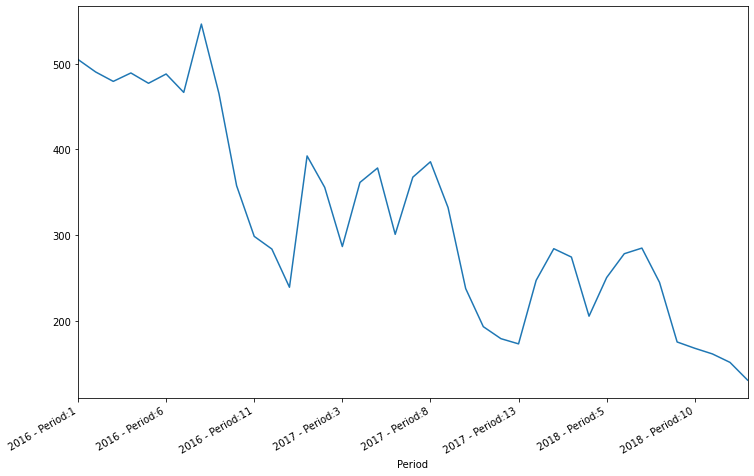

In [39]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 4
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [44]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[1.42184936]
 [1.28694378]
 [1.18518127]
 [1.27611081]]

 Target temperature to predict
1.1646774173594237


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

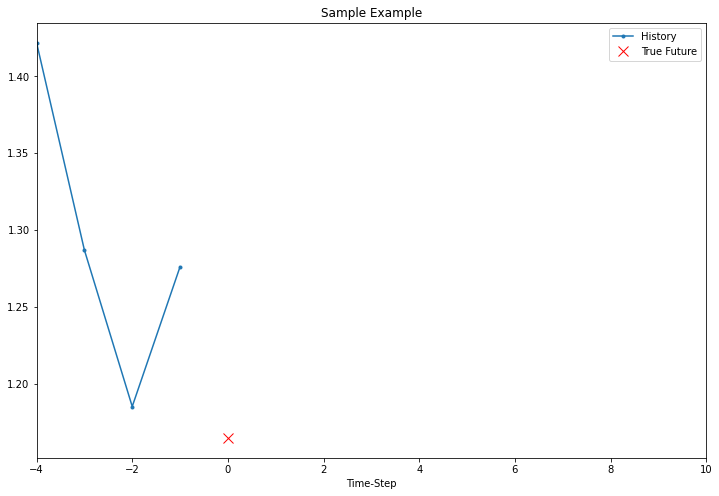

In [47]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

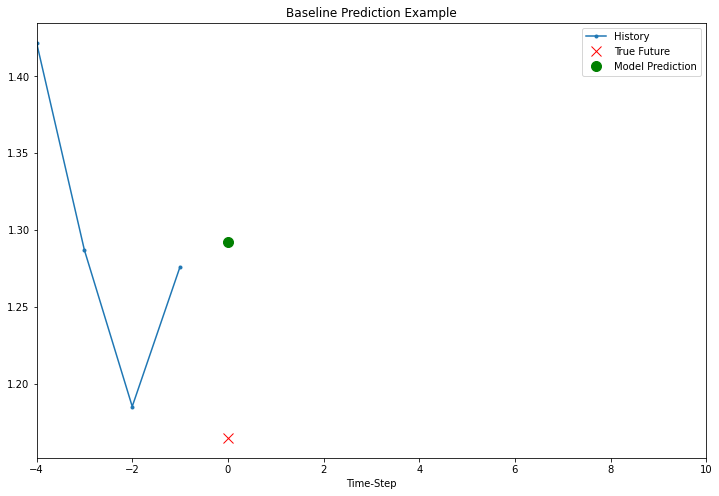

In [49]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [52]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(5, 1)


In [55]:
EVALUATION_INTERVAL = 2
EPOCHS = 5

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 2 steps, validate for 50 steps
Epoch 1/5
2/2 [==============================] - 0s 60ms/step - loss: 0.2966 - val_loss: 0.5556
Epoch 2/5
2/2 [==============================] - 0s 48ms/step - loss: 0.2966 - val_loss: 0.5603
Epoch 3/5
2/2 [==============================] - 0s 48ms/step - loss: 0.2965 - val_loss: 0.5580
Epoch 4/5
2/2 [==============================] - 0s 46ms/step - loss: 0.2959 - val_loss: 0.5600
Epoch 5/5
2/2 [==============================] - 0s 48ms/step - loss: 0.2957 - val_loss: 0.5592


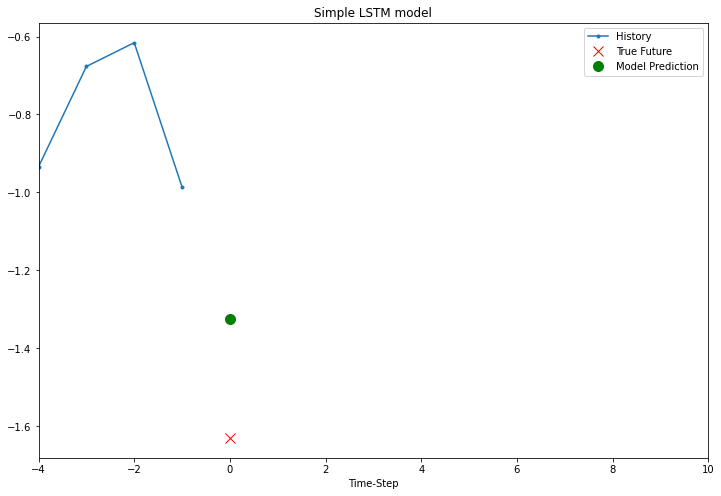

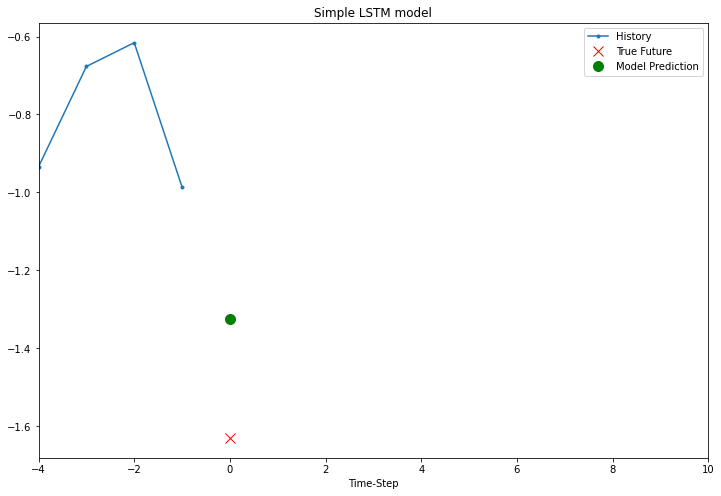

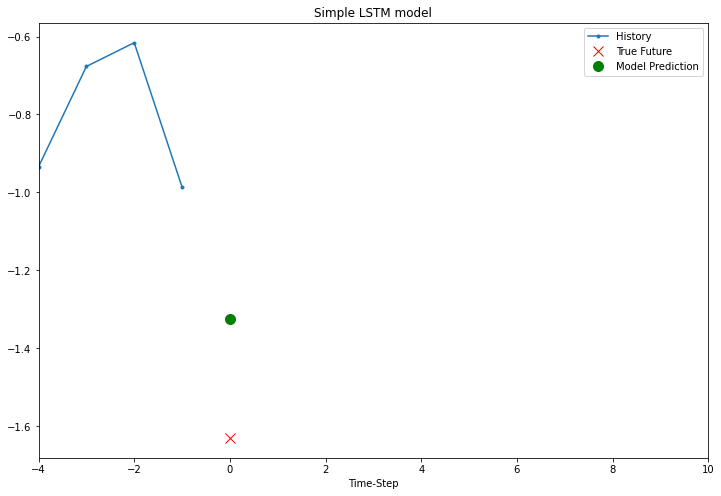

In [56]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()